<a href="https://colab.research.google.com/github/pyijiezhang/cold-posteriors-and-pacbayes/blob/main/results/bnn_classification_mfvi/results_vi_nn_classification_andres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def get_metrics(results):

    metrics_dict = {}

    for seed in results.keys():

        result_seed = results[seed]
        cpe_weights = list(result_seed.keys())
        # cpe_weights.remove("setting")

        _, n_post_samples = result_seed[cpe_weights[0]][0].shape

        metrics_dict[seed] = {}

        metrics_dict[seed]["nll_gibbs_train"] = []
        metrics_dict[seed]["nll_gibbs_test"] = []
        metrics_dict[seed]["nll_bayes_train"] = []
        metrics_dict[seed]["nll_bayes_test"] = []

        metrics_dict[seed]["err_gibbs_train"] = []
        metrics_dict[seed]["err_gibbs_test"] = []
        metrics_dict[seed]["err_bayes_train"] = []
        metrics_dict[seed]["err_bayes_test"] = []

        # metrics_dict[seed]["grad_nll_gibbs"]=[]

        for cpe_weight in cpe_weights:

            log_p_train = torch.tensor(result_seed[cpe_weight][0])
            log_p_test = torch.tensor(result_seed[cpe_weight][1])

            metrics_dict[seed]["nll_gibbs_train"].append(-log_p_train.mean().item())
            metrics_dict[seed]["nll_gibbs_test"].append(-log_p_test.mean().item())

            bayes_loss_train = (
                (
                    torch.log(torch.tensor(n_post_samples))
                    - torch.logsumexp(log_p_train, 1)
                )
                .mean()
                .item()
            )
            metrics_dict[seed]["nll_bayes_train"].append(bayes_loss_train)
            bayes_loss_test = (
                (
                    torch.log(torch.tensor(n_post_samples))
                    - torch.logsumexp(log_p_test, 1)
                )
                .mean()
                .item()
            )
            metrics_dict[seed]["nll_bayes_test"].append(bayes_loss_test)

            # grad_expected_gibbs = (
            #         -n_train
            #         * (
            #             (log_p_train.mean(0) * log_p_test.mean(0)).mean()
            #             - log_p_test.mean() * log_p_train.mean()
            #         ).item()
            #     )
            # metrics_dict[seed]["grad_nll_gibbs"].append(grad_expected_gibbs)

            metrics_dict[seed]["err_gibbs_train"].append(
                1 - np.array(result_seed[cpe_weight][2])[:, 1].mean()
            )
            metrics_dict[seed]["err_gibbs_test"].append(
                1 - np.array(result_seed[cpe_weight][3])[:, 1].mean()
            )
            metrics_dict[seed]["err_bayes_train"].append(
                1 - np.array(result_seed[cpe_weight][4])[:, 1].mean()
            )
            metrics_dict[seed]["err_bayes_test"].append(
                1 - np.array(result_seed[cpe_weight][5])[:, 1].mean()
            )

    return metrics_dict


# in-between seeds

In [3]:
# dir_prefix = f"./between seeds/{setting_i}/"
# if not os.path.exists(dir_prefix):
#     os.makedirs(dir_prefix)


In [4]:
# name_metrics=list(metrics[seeds[0]].keys())
# for name_metric in name_metrics:
#     save_name=f"{name_metric}"
#     plt.figure()
#     plt.title(save_name)
#     for seed in seeds:
#         plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][name_metric], marker="o", label=f"{seed}")

#     plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
#     plt.legend()
#     plt.xlabel("lambda, log scale")
#     plt.ylabel(name_metric)
#     plt.ylim(0,0.1)
#     # plt.savefig(f"./{dir_prefix}/{save_name}.png", dpi=300)
#     plt.show()


# main plots
## prior

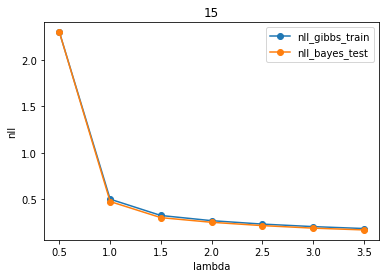

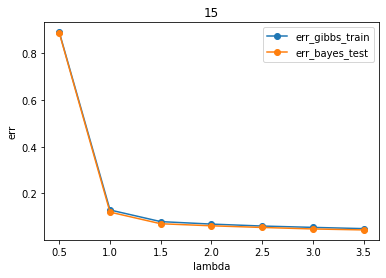

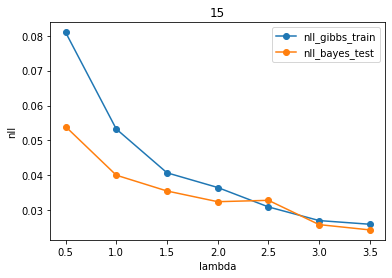

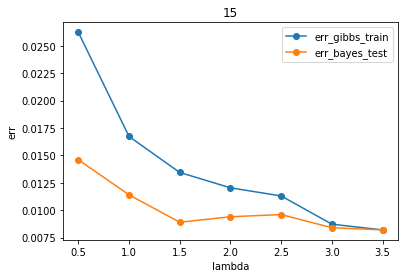

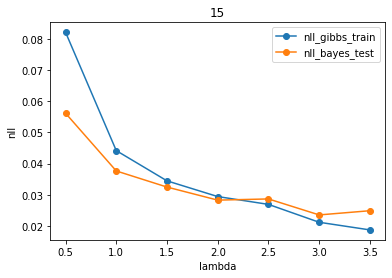

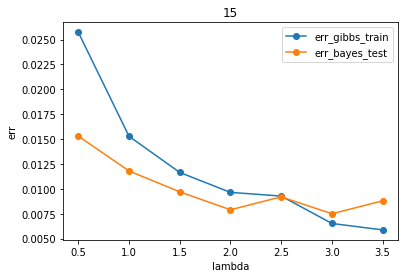

In [32]:
all_metrics_priors = {}
for prior_scale in [0.01, 0.1, 1.0]:
    setting_i = f"prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_priors[prior_scale] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [7]:
name_metric = "err_bayes_test"
name_seed = 15
df = pd.DataFrame()
for prior_scale in [0.01, 0.1, 1.0]:
    this_df = pd.DataFrame.from_dict(all_metrics_priors[prior_scale][name_seed])[name_metric]
    this_df.rename(prior_scale, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


In [ ]:
df


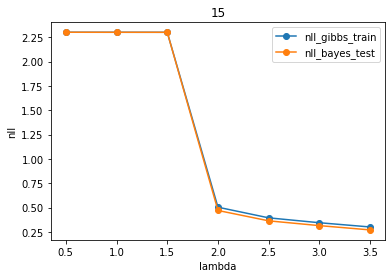

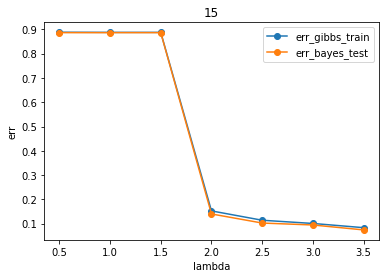

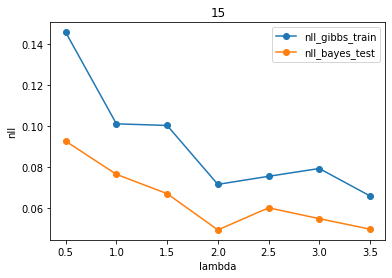

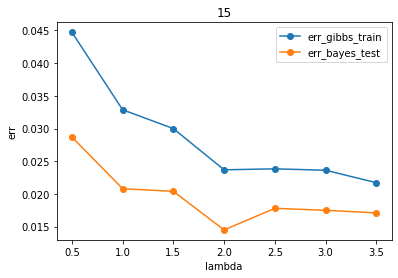

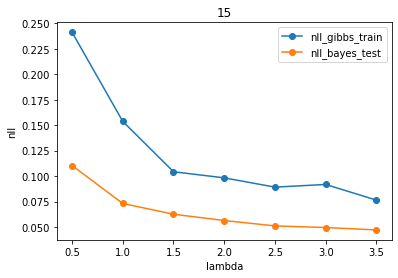

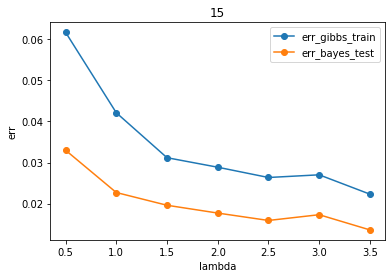

In [33]:
all_metrics_priors_aug = {}
for prior_scale in [0.01, 0.1, 1.0]:
    setting_i = f"prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_True"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_priors_aug[prior_scale] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


## label noise

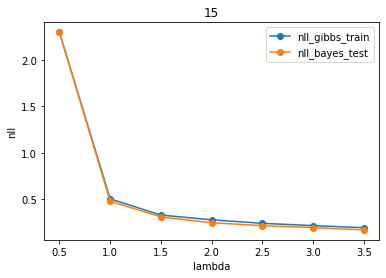

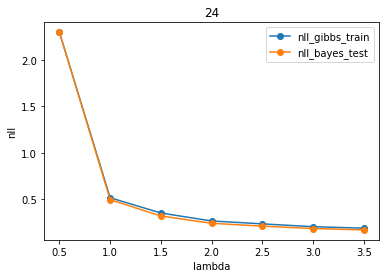

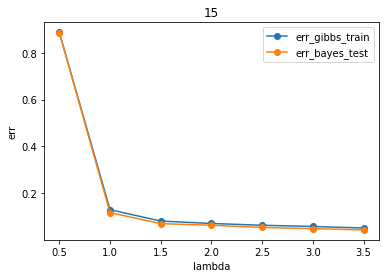

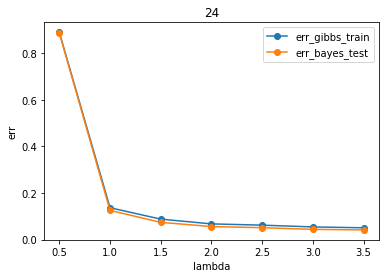

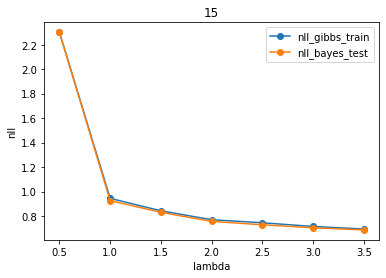

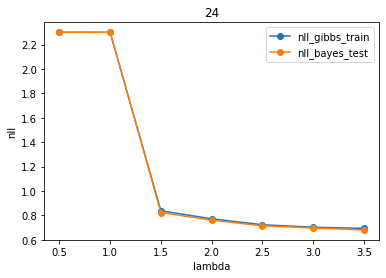

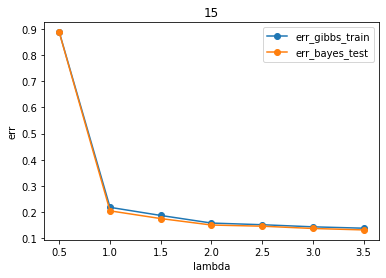

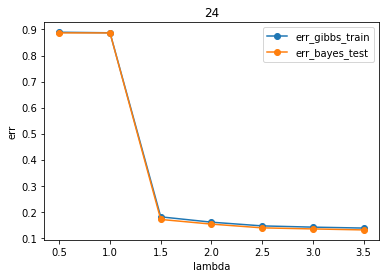

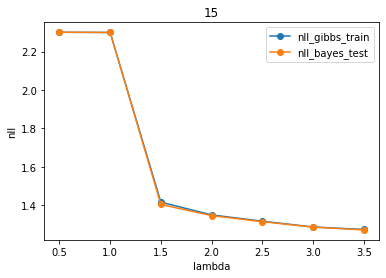

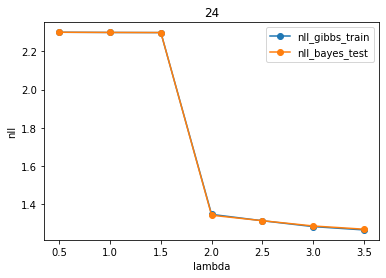

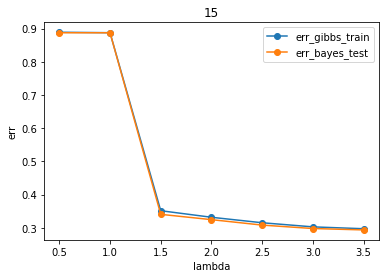

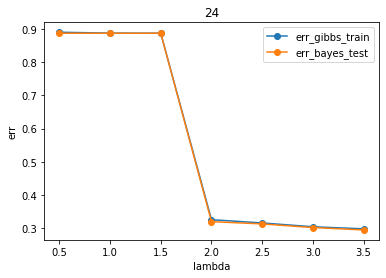

In [ ]:
all_metrics_noise = {}
for label_noise in [0.0, 0.1, 0.2]:
    setting_i = f"prior_scale_0.01_label_noise_{label_noise}_smooth_softmax_1.0_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_noise[label_noise] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [ ]:
name_metric = "nll_bayes_test"
name_seed = 24
df = pd.DataFrame()
for label_noise in [0.0, 0.1, 0.2]:
    this_df = pd.DataFrame.from_dict(all_metrics_noise[label_noise][name_seed])[name_metric]
    this_df.rename(label_noise, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


In [ ]:
df


,0.0,0.1,0.2
0.5,2.301938,2.301750,2.300560
1.0,0.492622,2.301353,2.299532
1.5,0.315786,0.823026,2.298934
2.0,0.237219,0.760369,1.340986
2.5,0.206292,0.714444,1.312364
3.0,0.180682,0.696535,1.284727
3.5,0.165488,0.680415,1.267840


## smooth softmax

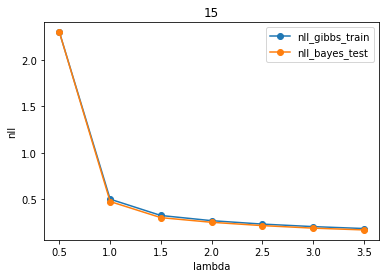

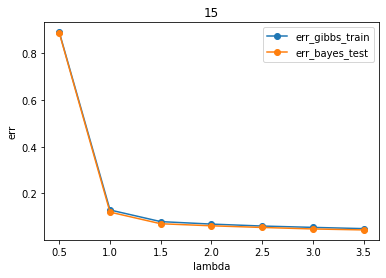

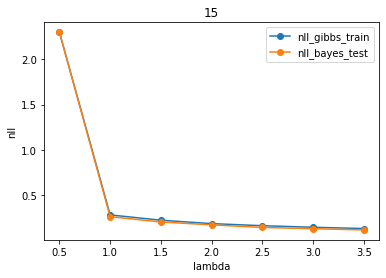

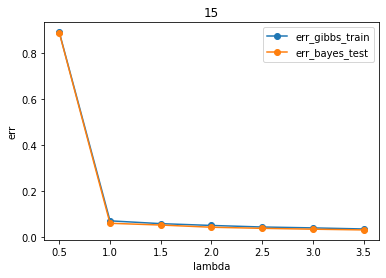

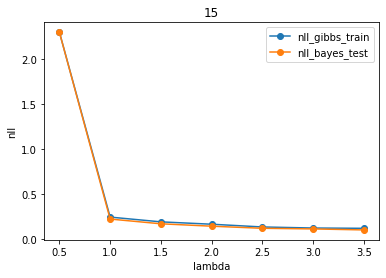

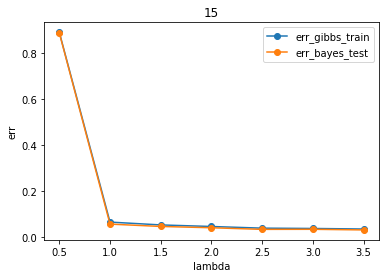

In [9]:
all_metrics_softmax = {}
for gamma in [1.0, 5.0, 10.0]:
    setting_i = f"prior_scale_0.01_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_softmax[gamma] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


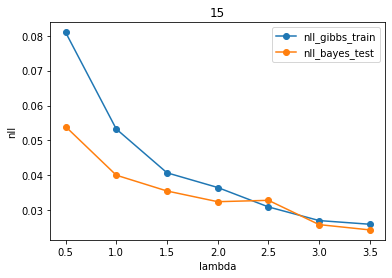

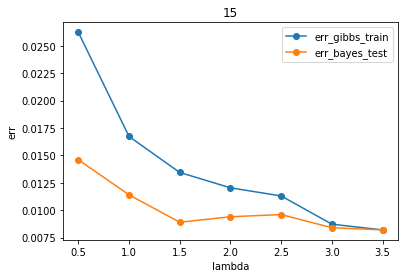

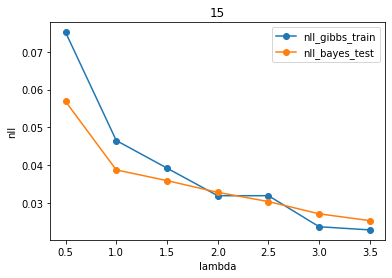

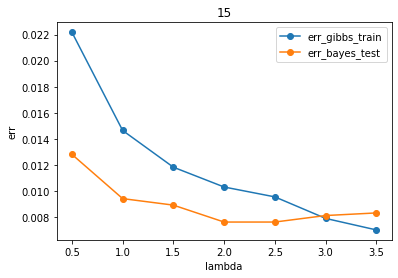

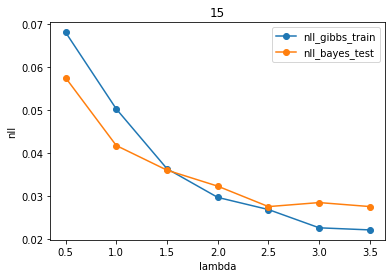

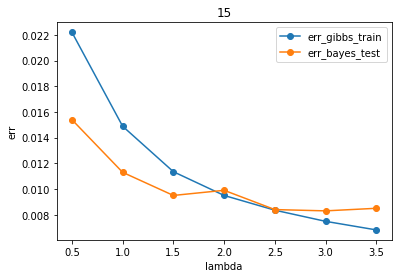

In [18]:
all_metrics_softmax_prior = {}
for gamma in [1.0, 5.0, 10.0]:
    setting_i = f"prior_scale_0.1_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics_softmax_prior[gamma] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [11]:
name_metric = "nll_bayes_test"
name_seed = 15
df = pd.DataFrame()
for gamma in [1.0, 3.0, 5.0, 10.0]:
    this_df = pd.DataFrame.from_dict(all_metrics_softmax[gamma][name_seed])[name_metric]
    this_df.rename(gamma, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


KeyError: ignored

In [12]:
df


,1.0
0,2.301839
1,0.472233
2,0.298221
3,0.247979
4,0.212168
5,0.184917
6,0.165641



# Joint Plots - Softmax


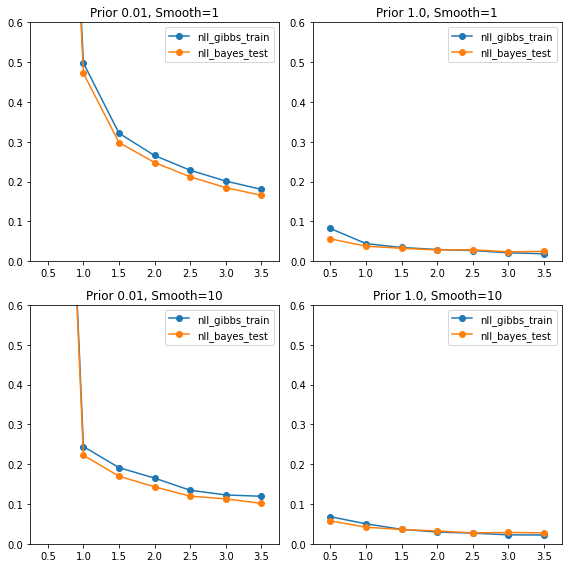

In [387]:
import matplotlib.pyplot as plt
import numpy as np

seed=15
train_loss = "nll_gibbs_train"
test_loss = "nll_bayes_test"
y_lim=[0,0.6]
x_lim=[0.25,3.75]
# generate some random data
x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(x)

# create a 2x2 grid of subplots with larger subplots and spacing
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

prior=0.01

# plot the data on each subplot and set the limits
axs[0, 0].plot(cpe_weights, all_metrics_priors[prior][seed][train_loss], marker="o", label=train_loss)
axs[0, 0].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss], marker="o", label=test_loss)
axs[0, 0].set_xlim(x_lim)
axs[0, 0].set_ylim(y_lim)
axs[0, 0].set_title("Prior 0.01, Smooth=1")
axs[0, 0].legend()


prior=1.0
axs[0, 1].plot(cpe_weights, all_metrics_priors[prior][seed][train_loss], marker="o", label=train_loss)
axs[0, 1].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss], marker="o", label=test_loss)
axs[0, 1].set_xlim(x_lim)
axs[0, 1].set_ylim(y_lim)
axs[0, 1].set_title("Prior 1.0, Smooth=1")
axs[0, 1].legend()



gamma=10.0
axs[1, 0].plot(cpe_weights, all_metrics_softmax[gamma][seed][train_loss], marker="o", label=train_loss)
axs[1, 0].plot(cpe_weights, all_metrics_softmax[gamma][seed][test_loss], marker="o", label=test_loss)
axs[1, 0].set_xlim(x_lim)
axs[1, 0].set_ylim(y_lim)
axs[1, 0].set_title("Prior 0.01, Smooth=10")
axs[1, 0].legend()


gamma=10.0
axs[1, 1].plot(cpe_weights, all_metrics_softmax_prior[gamma][seed][train_loss], marker="o", label=train_loss)
axs[1, 1].plot(cpe_weights, all_metrics_softmax_prior[gamma][seed][test_loss], marker="o", label=test_loss)
axs[1, 1].set_xlim(x_lim)
axs[1, 1].set_ylim(y_lim)
axs[1, 1].set_title("Prior 1.0, Smooth=10")
axs[1, 1].legend()



# adjust the spacing between subplots
fig.tight_layout()

# show the plot
plt.show()


# Joint Plots Data Augmentation

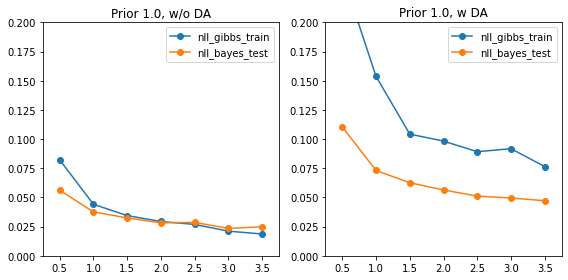

In [374]:
import matplotlib.pyplot as plt
import numpy as np

prior=1.0

seed=15
train_loss = "nll_gibbs_train"
test_loss = "nll_bayes_test"
y_lim=[0,0.2]
x_lim=[0.25,3.75]
# generate some random data
x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(x)

# create a 2x2 grid of subplots with larger subplots and spacing
fig, axs = plt.subplots(1, 2, figsize=(8, 4))


# plot the data on each subplot and set the limits
axs[0].plot(cpe_weights, all_metrics_priors[prior][seed][train_loss], marker="o", label=train_loss)
axs[0].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss], marker="o", label=test_loss)
axs[0].set_xlim(x_lim)
axs[0].set_ylim(y_lim)
axs[0].set_title(f"Prior {prior}, w/o DA")
axs[0].legend()


axs[1].plot(cpe_weights, all_metrics_priors_aug[prior][seed][train_loss], marker="o", label=train_loss)
axs[1].plot(cpe_weights, all_metrics_priors_aug[prior][seed][test_loss], marker="o", label=test_loss)
axs[1].set_xlim(x_lim)
axs[1].set_ylim(y_lim)
axs[1].set_title(f"Prior {prior}, w DA")
axs[1].legend()



# adjust the spacing between subplots
fig.tight_layout()

# show the plot
plt.show()


# Exploring Data Augmentation

In [250]:
seed=15
prior=1.0
lamb=1.0
da=True
setting_i = f"prior_scale_{prior}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_{da}"

with open(f"{setting_i}.pickle", "rb") as handle:
  results = pickle.load(handle)


print(results[seed][lamb][0].shape)

log_p_train = np.sum(results[seed][lamb][0],axis=0)
log_p_test = results[seed][lamb][1]
prob_test = np.exp(log_p_test)

log_p_train = np.tile(log_p_train, (prob_test.shape[0], 1))
cov = np.mean(log_p_train*prob_test,axis=1) - np.mean(log_p_train,axis=1)*np.mean(prob_test,axis=1)
prob_mean = np.mean(prob_test,axis=1)
cov_mean = np.mean(cov/prob_mean)

#plt.boxplot(results[seed][lamb][0]);
np.min(cov)

(60000, 10)


-173.43262

## Gradient Bayes Loss

In [304]:
def gradientBayesLoss(seed, prior, lamb, da):

  setting_i = f"prior_scale_{prior}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_{da}"

  with open(f"{setting_i}.pickle", "rb") as handle:
    results = pickle.load(handle)


  log_p_train = np.sum(results[seed][lamb][0],axis=0)
  log_p_test = results[seed][lamb][1]
  prob_test = np.exp(log_p_test)

  log_p_train = np.tile(log_p_train, (prob_test.shape[0], 1))

  cov = np.mean(log_p_train*prob_test,axis=1) - np.mean(log_p_train,axis=1)*np.mean(prob_test,axis=1)
  prob_mean = np.mean(prob_test,axis=1)
  cov_mean = np.mean(cov/prob_mean)
  return -cov_mean, -cov, prob_mean

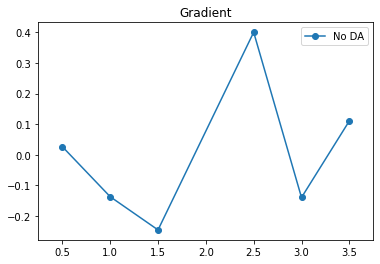

In [368]:
seed=15
prior=1.0
da=True
lambdas = [0.5, 1.0, 1.5, 2.5, 3.0, 3.5]
#vals = [gradientBayesLoss(seed, prior, lamb, da)[0] for lamb in lambdas]
#plt.plot(lambdas,vals, marker="o", label="DA")
da=False
vals = [gradientBayesLoss(seed, prior, lamb, da)[0] for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="No DA")
plt.xlim(x_lim)
plt.title("Gradient")
plt.legend()

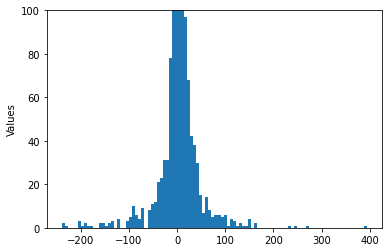

In [224]:
seed=15
prior=0.1
_, cov_da, prob_mean_da = covgradient(seed, prior, 1.0, True)
_, cov_noda, prob_mean_noda = covgradient(seed, prior, 1.0, False)

fig, ax = plt.subplots()

# Create two box plots at positions 1 and 2
#ax.boxplot([cov_da, cov_noda], positions=[1, 2])
#ax.boxplot([prob_mean_da, prob_mean_noda], positions=[1, 2])
ax.hist([cov_noda/prob_mean_noda], bins=100)
#ax.hist([prob_mean_da, prob_mean_noda], bins=100, density=True)
ax.set_ylim([0.0,100])
# Set the x-axis tick labels
#ax.set_xticklabels(['DA', 'NO '])

# Set the y-axis label
ax.set_ylabel('Values')

# Show the plot
plt.show()



## Gradient Gibbs Loss

In [321]:
def gradientGibbsLoss(seed, prior, lamb, da):

  setting_i = f"prior_scale_{prior}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_{da}"

  with open(f"{setting_i}.pickle", "rb") as handle:
    results = pickle.load(handle)


  log_p_train = np.sum(results[seed][lamb][0],axis=0)
  log_p_test = -np.mean(results[seed][lamb][1],axis=0)

  cov = np.mean(log_p_train*log_p_test,axis=0) - np.mean(log_p_train,axis=0)*np.mean(log_p_test,axis=0)
  return np.cov(log_p_train,log_p_test)[0, 1]

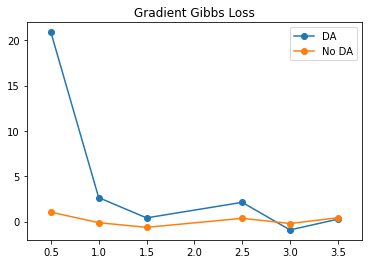

In [323]:
seed=15
prior=1.0
da=True
lambdas = [0.5, 1.0, 1.5, 2.5, 3.0, 3.5]
vals = [gradientGibbsLoss(seed, prior, lamb, da) for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="DA")
da=False
vals = [gradientGibbsLoss(seed, prior, lamb, da) for lamb in lambdas]
plt.plot(lambdas,vals, marker="o", label="No DA")
plt.xlim(x_lim)
plt.title("Gradient Gibbs Loss")
plt.legend()

In [358]:
def scatter(seed, prior, lamb, da):

  setting_i = f"prior_scale_{prior}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_{da}"

  with open(f"{setting_i}.pickle", "rb") as handle:
    results = pickle.load(handle)


  log_p_train = -np.sum(results[seed][lamb][0],axis=0)
  log_p_test = -np.mean(results[seed][lamb][1],axis=0)

  plt.scatter(log_p_train,log_p_test)

  return np.cov(log_p_train,log_p_test)[0, 1]

-2.6369275224178432

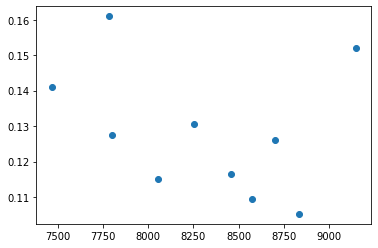

In [365]:
scatter(seed, 1.0, 1.0, True)

# Label Noise

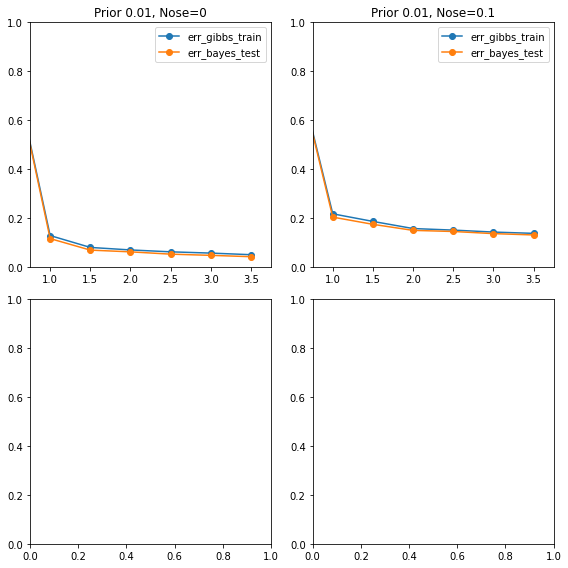

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

seed=15
train_loss = "err_gibbs_train"
test_loss = "err_bayes_test"
y_lim=[0,1.0]
x_lim=[0.75,3.75]
# generate some random data
x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(x)

# create a 2x2 grid of subplots with larger subplots and spacing
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

prior=0.01

# plot the data on each subplot and set the limits
axs[0, 0].plot(cpe_weights, all_metrics_priors[prior][seed][train_loss], marker="o", label=train_loss)
axs[0, 0].plot(cpe_weights, all_metrics_priors[prior][seed][test_loss], marker="o", label=test_loss)
axs[0, 0].set_xlim(x_lim)
axs[0, 0].set_ylim(y_lim)
axs[0, 0].set_title("Prior 0.01, Nose=0")
axs[0, 0].legend()


noise=0.1
axs[0, 1].plot(cpe_weights, all_metrics_noise[noise][seed][train_loss], marker="o", label=train_loss)
axs[0, 1].plot(cpe_weights, all_metrics_noise[noise][seed][test_loss], marker="o", label=test_loss)
axs[0, 1].set_xlim(x_lim)
axs[0, 1].set_ylim(y_lim)
axs[0, 1].set_title("Prior 0.01, Nose=0.1")
axs[0, 1].legend()






# adjust the spacing between subplots
fig.tight_layout()

# show the plot
plt.show()


In [383]:
!tar -cvf myfiles.tar *.pickle

prior_scale_0.01_label_noise_0.0_smooth_softmax_10.0_data_augmentation_False.pickle
prior_scale_0.01_label_noise_0.0_smooth_softmax_10.0_data_augmentation_True.pickle
prior_scale_0.01_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False.pickle
prior_scale_0.01_label_noise_0.0_smooth_softmax_1.0_data_augmentation_True.pickle
prior_scale_0.01_label_noise_0.0_smooth_softmax_5.0_data_augmentation_False.pickle
prior_scale_0.01_label_noise_0.0_smooth_softmax_5.0_data_augmentation_True.pickle
prior_scale_0.1_label_noise_0.0_smooth_softmax_10.0_data_augmentation_False.pickle
prior_scale_0.1_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False.pickle
prior_scale_0.1_label_noise_0.0_smooth_softmax_1.0_data_augmentation_True.pickle
prior_scale_0.1_label_noise_0.0_smooth_softmax_5.0_data_augmentation_False.pickle
prior_scale_1.0_label_noise_0.0_smooth_softmax_10.0_data_augmentation_False.pickle
prior_scale_1.0_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False.pickle
prior_scal

In [389]:
from google.colab import files
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>